In [25]:
import torch
import torchvision 
from torchvision import transforms, models, datasets
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from collections import OrderedDict
from PIL import Image
import seaborn as ss
import pandas as pd

In [29]:
import os
from glob import glob

In [22]:
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader,Dataset

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [56]:
data_dir = {
    "train" : "/media/brats/DRIVE1/akansh/DeepXrays/Data/processed/Chest_XR_covid_clahe/train/",
    "valid": "/media/brats/DRIVE1/akansh/DeepXrays/Data/processed/Chest_XR_covid_clahe/validate/",
    "test" : "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/test/"
}

In [57]:
label_csv = {"train": '/media/brats/DRIVE1/akansh/DeepXrays/Data/processed/train_labels.csv',
            "valid": "/media/brats/DRIVE1/akansh/DeepXrays/Data/processed/validation_labels.csv",
            "test": "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/submission.csv"}

In [58]:
### Dataloader
class covid_dataset(Dataset):
    def __init__(self, image_loc, label_loc, transform, data_type = 'train'):
        filenames = []
        for root, dirs, files in os.walk(image_loc):
            for file in files:
                if file.endswith('.jpg') == True or file.endswith('.png') == True :
                    filenames.append(file)
#         print(len(filenames))
        if data_type == 'train' or data_type == 'valid':
            self.full_filenames = glob(image_loc+'*/*.*')
        else:
            self.full_filenames = glob(image_loc+'*.*')
#         print(len(self.full_filenames))
            
            
        label_df = pd.read_csv(label_loc)
        label_df.set_index("case", inplace = True)
        self.labels = [label_df.loc[filename].values[0] for filename in filenames]
        
        self.transform = transform
        
    def __len__(self):
        return len(self.full_filenames)
    
    def __getitem__(self,idx):
        image = Image.open(self.full_filenames[idx])
#         image = image.convert('RGB')
#         image = Image.fromarray(exposure.adjust_gamma(np.array(image), gamma = 0.6))
        
        image = self.transform(image)
        return image, self.labels[idx]
        

In [59]:
batch_size = 64

data_transforms = {
    
    'train': transforms.Compose([
#         transforms.Resize((256,256)),
#         transforms.CenterCrop((224,224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation((-20,20)),
        transforms.ToTensor(),
        transforms.Normalize([0.5027,0.5027,0.5027],[0.2466, 0.2466, 0.2466])
        
    ]),
    
    'valid' : transforms.Compose([
#         transforms.Resize((224,224)),
#         transforms.CenterCrop((254,254)),
        transforms.ToTensor(),
        transforms.Normalize([0.5027,0.5027,0.5027],[0.2466, 0.2466, 0.2466])
    ])
    
    
}

In [60]:
valid_data = covid_dataset(image_loc = data_dir['valid'],
                          label_loc = label_csv['valid'],
                          transform = data_transforms['valid'],
                          data_type = 'valid')

train_data = covid_dataset(image_loc = data_dir['train'],
                          label_loc = label_csv['train'],
                          transform = data_transforms['train'],
                          data_type = 'train')


trainloader = DataLoader(train_data,batch_size = 64,shuffle = True)
validloader = DataLoader(valid_data,batch_size = 32,shuffle = False)

In [41]:
for x,y in train_data:
    print(x.shape)
    print(y)
    break

torch.Size([3, 224, 224])
0


In [42]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(train_data.labels), train_data.labels) 
print(class_weights)
sample_weights = [0]*len(train_data)
for idx, (data,label) in tqdm(enumerate(train_data)):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight
from torch.utils.data import WeightedRandomSampler
sampler = sampler = WeightedRandomSampler(sample_weights, num_samples = len(sample_weights), replacement = True)

[0.91613101 0.83708572 1.4008893 ]


0it [00:00, ?it/s]

In [61]:
data_loader={
        'train': torch.utils.data.DataLoader(train_data, batch_size=64,shuffle=False, sampler = sampler),
        'valid': torch.utils.data.DataLoader(valid_data, batch_size=32,shuffle=False),
        }
# data_loader={
#         'train': torch.utils.data.DataLoader(data_set['train'], batch_size=64,shuffle=False),
#         'valid': torch.utils.data.DataLoader(data_set['valid'], batch_size=32,shuffle=False),
#         }

In [44]:
_ = data_set['valid'].class_to_idx
cat_to_name = {_[i]: i for i in list(_.keys())}


In [45]:
cat_to_name

{0: 'covid', 1: 'normal', 2: 'pneumonia'}

In [62]:
model = models.densenet121(pretrained=True)

for param in model.parameters():
    param.requires_grad = True


In [63]:
model.classifier = nn.Sequential(OrderedDict([
    ('fcl1', nn.Linear(1024,256)),
    ('dp1', nn.Dropout(0.3)),
    ('r1', nn.ReLU()),
    ('fcl2', nn.Linear(256,32)),
    ('dp2', nn.Dropout(0.3)),
    ('r2', nn.ReLU()),
    ('fcl3', nn.Linear(32,3)),
    ('out', nn.LogSoftmax(dim=1)),
]))


In [64]:
from tqdm.notebook import tqdm

In [65]:
def accuracy(y_pred,y_true):
    y_pred = torch.exp(y_pred)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [66]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1,patience = 5)
epochs = 40
valid_loss_min = np.Inf

In [67]:
device = 'cuda'

In [68]:
model = model.cuda()

In [69]:
train_loss_hist = []
valid_loss_hist = []
train_acc_hist = []
valid_acc_hist = []
valid_acc_min = 0

for i in range(epochs):
    
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0 
    
    
    model.train()
    
    for images,labels in tqdm(data_loader['train']):
        
        images = images.to(device)
        labels = labels.to(device)
        
        ps = model(images)
        loss = criterion(ps,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_acc += accuracy(ps,labels)
        train_loss += loss.item()
        
    avg_train_acc = train_acc / len(data_loader['train'])
    train_acc_hist.append(avg_train_acc)
    avg_train_loss = train_loss / len(data_loader['train'])
    train_loss_hist.append(avg_train_loss)
        
    model.eval()
    with torch.no_grad():
        
        for images,labels in tqdm(data_loader['valid']):
            
            images = images.to(device)
            labels = labels.to(device)
            
            ps = model(images)
            loss = criterion(ps,labels)
            
            valid_acc += accuracy(ps,labels)
            valid_loss += loss.item()
            
            
        avg_valid_acc = valid_acc / len(data_loader['valid'])
        valid_acc_hist.append(avg_valid_acc)
        avg_valid_loss = valid_loss / len(data_loader['valid'])
        valid_loss_hist.append(avg_valid_loss)
        
        schedular.step(avg_valid_loss)
        
        if avg_valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_loss_min,avg_valid_loss))
            torch.save({
                'epoch' : i,
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
                'valid_loss_min' : avg_valid_loss
            },'DenseNet_size224clahe.pt')
            
            valid_loss_min = avg_valid_loss
            
        if avg_valid_acc >= valid_acc_min:
            print('Validation Accuracy increase ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_acc_min,avg_valid_acc))
            torch.save({
                'epoch' : i,
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
                'valid_loss_min' : avg_valid_loss
            },'DenseNet_size_224clahe_best_acc.pt')
            
            valid_acc_min = avg_valid_acc
            
            
    print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1,avg_train_loss,avg_train_acc))
    print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1,avg_valid_loss,avg_valid_acc))


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.602368).   Saving model ...
Validation Accuracy increase (0.000000 --> 0.793113).   Saving model ...
Epoch : 1 Train Loss : 0.469326 Train Acc : 0.823911
Epoch : 1 Valid Loss : 0.602368 Valid Acc : 0.793113


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.602368 --> 0.286799).   Saving model ...
Validation Accuracy increase (0.793113 --> 0.903935).   Saving model ...
Epoch : 2 Train Loss : 0.321305 Train Acc : 0.887043
Epoch : 2 Valid Loss : 0.286799 Valid Acc : 0.903935


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.282315 Train Acc : 0.900095
Epoch : 3 Valid Loss : 0.314819 Valid Acc : 0.880787


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.249191 Train Acc : 0.912972
Epoch : 4 Valid Loss : 0.319123 Valid Acc : 0.901910


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.286799 --> 0.190271).   Saving model ...
Validation Accuracy increase (0.903935 --> 0.934028).   Saving model ...
Epoch : 5 Train Loss : 0.239749 Train Acc : 0.918296
Epoch : 5 Valid Loss : 0.190271 Valid Acc : 0.934028


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.222369 Train Acc : 0.924038
Epoch : 6 Valid Loss : 0.323472 Valid Acc : 0.885706


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.196401 Train Acc : 0.931843
Epoch : 7 Valid Loss : 0.236780 Valid Acc : 0.923032


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.200156 Train Acc : 0.932531
Epoch : 8 Valid Loss : 0.212057 Valid Acc : 0.929398


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.184312 Train Acc : 0.936944
Epoch : 9 Valid Loss : 0.278734 Valid Acc : 0.914931


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.184241 Train Acc : 0.936868
Epoch : 10 Valid Loss : 0.209192 Valid Acc : 0.920139


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 11 Train Loss : 0.178600 Train Acc : 0.936663
Epoch : 11 Valid Loss : 0.252842 Valid Acc : 0.912905


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.190271 --> 0.154764).   Saving model ...
Validation Accuracy increase (0.934028 --> 0.949653).   Saving model ...
Epoch : 12 Train Loss : 0.131214 Train Acc : 0.954866
Epoch : 12 Valid Loss : 0.154764 Valid Acc : 0.949653


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 13 Train Loss : 0.115536 Train Acc : 0.961317
Epoch : 13 Valid Loss : 0.179833 Valid Acc : 0.940104


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.154764 --> 0.146617).   Saving model ...
Validation Accuracy increase (0.949653 --> 0.951678).   Saving model ...
Epoch : 14 Train Loss : 0.108296 Train Acc : 0.962077
Epoch : 14 Valid Loss : 0.146617 Valid Acc : 0.951678


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 15 Train Loss : 0.103526 Train Acc : 0.964208
Epoch : 15 Valid Loss : 0.154205 Valid Acc : 0.949942


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 0.100154 Train Acc : 0.965449
Epoch : 16 Valid Loss : 0.161937 Valid Acc : 0.946470


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 17 Train Loss : 0.082412 Train Acc : 0.971030
Epoch : 17 Valid Loss : 0.167380 Valid Acc : 0.948785


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 18 Train Loss : 0.093253 Train Acc : 0.967451
Epoch : 18 Valid Loss : 0.182417 Valid Acc : 0.943287


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation Accuracy increase (0.951678 --> 0.952836).   Saving model ...
Epoch : 19 Train Loss : 0.081973 Train Acc : 0.970140
Epoch : 19 Valid Loss : 0.160872 Valid Acc : 0.952836


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 0.080487 Train Acc : 0.973365
Epoch : 20 Valid Loss : 0.154398 Valid Acc : 0.950810


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 21 Train Loss : 0.074231 Train Acc : 0.974311
Epoch : 21 Valid Loss : 0.179634 Valid Acc : 0.944734


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 22 Train Loss : 0.067446 Train Acc : 0.977091
Epoch : 22 Valid Loss : 0.165878 Valid Acc : 0.948206


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 23 Train Loss : 0.077116 Train Acc : 0.973087
Epoch : 23 Valid Loss : 0.164409 Valid Acc : 0.949942


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 24 Train Loss : 0.070328 Train Acc : 0.976942
Epoch : 24 Valid Loss : 0.158485 Valid Acc : 0.950810


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 25 Train Loss : 0.067371 Train Acc : 0.977070
Epoch : 25 Valid Loss : 0.161642 Valid Acc : 0.950810


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 26 Train Loss : 0.065158 Train Acc : 0.976757
Epoch : 26 Valid Loss : 0.172903 Valid Acc : 0.947627


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 27 Train Loss : 0.067346 Train Acc : 0.976160
Epoch : 27 Valid Loss : 0.171193 Valid Acc : 0.949653


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 28 Train Loss : 0.069856 Train Acc : 0.976719
Epoch : 28 Valid Loss : 0.161949 Valid Acc : 0.950810


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 29 Train Loss : 0.065943 Train Acc : 0.977313
Epoch : 29 Valid Loss : 0.164571 Valid Acc : 0.949942


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 30 Train Loss : 0.067655 Train Acc : 0.975051
Epoch : 30 Valid Loss : 0.165670 Valid Acc : 0.949653


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 31 Train Loss : 0.068481 Train Acc : 0.974550
Epoch : 31 Valid Loss : 0.177079 Valid Acc : 0.946470


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 32 Train Loss : 0.068785 Train Acc : 0.976052
Epoch : 32 Valid Loss : 0.164533 Valid Acc : 0.950521


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 33 Train Loss : 0.068040 Train Acc : 0.976883
Epoch : 33 Valid Loss : 0.164987 Valid Acc : 0.949942


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 34 Train Loss : 0.068051 Train Acc : 0.976813
Epoch : 34 Valid Loss : 0.176320 Valid Acc : 0.946759


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 35 Train Loss : 0.068168 Train Acc : 0.975551
Epoch : 35 Valid Loss : 0.169806 Valid Acc : 0.947627


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 36 Train Loss : 0.066662 Train Acc : 0.977220
Epoch : 36 Valid Loss : 0.160934 Valid Acc : 0.950231


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 37 Train Loss : 0.071712 Train Acc : 0.975162
Epoch : 37 Valid Loss : 0.161112 Valid Acc : 0.950231


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 38 Train Loss : 0.068457 Train Acc : 0.977237
Epoch : 38 Valid Loss : 0.172169 Valid Acc : 0.947917


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 39 Train Loss : 0.072819 Train Acc : 0.973921
Epoch : 39 Valid Loss : 0.171863 Valid Acc : 0.947338


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 40 Train Loss : 0.070189 Train Acc : 0.975033
Epoch : 40 Valid Loss : 0.175020 Valid Acc : 0.947627


Text(0, 0.5, 'Accuracy')

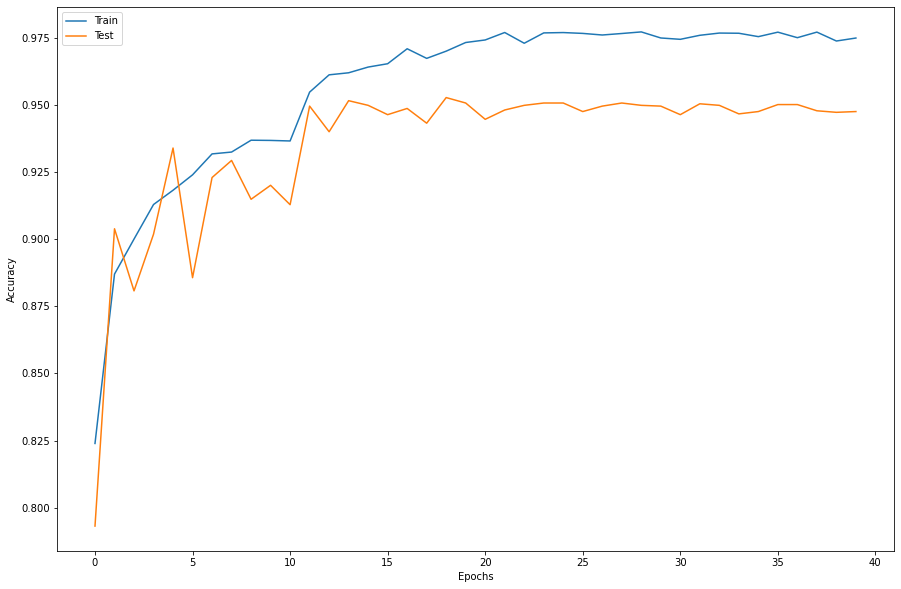

In [70]:
plt.figure(figsize=(15,10))
plt.plot(train_acc_hist, label = 'Train')
plt.plot(valid_acc_hist, label = 'Test')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

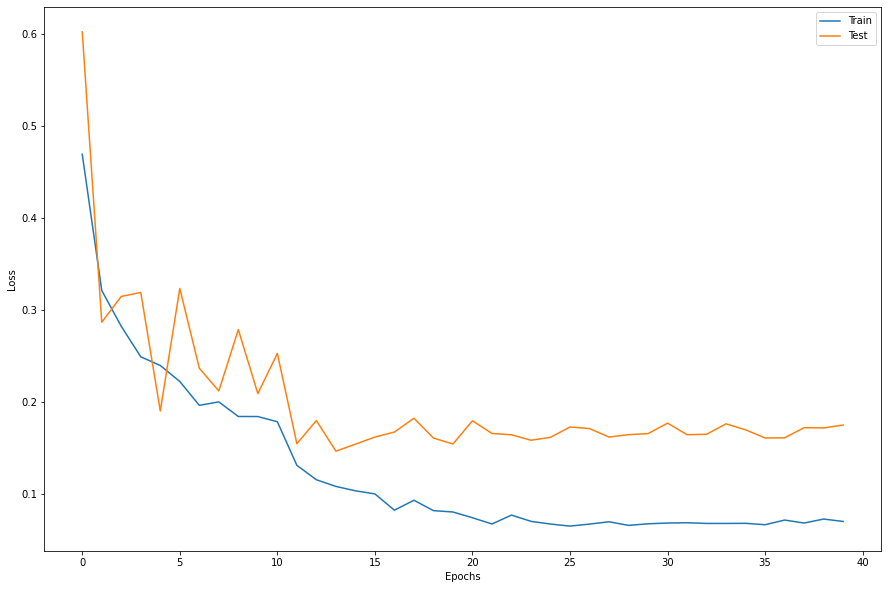

In [71]:
plt.figure(figsize=(15,10))
plt.plot(train_loss_hist, label = 'Train')
plt.plot(valid_loss_hist, label = 'Test')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [72]:
path2weights="/media/brats/DRIVE1/akansh/DeepXrays/Notebooks/Chest-XR-Grand_challenge/DenseNet_size_224_best_acc.pt"
model.load_state_dict(torch.load(path2weights)['model_state_dict'])
model.eval()

model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [45]:
nb_classes = 3
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in tqdm(enumerate(data_loader['valid'])):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes, preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

0it [00:00, ?it/s]

In [73]:
import pandas as pd
import seaborn as sns

In [ ]:
plt.figure(figsize=(15,10))

class_names = data_loader['valid'].dataset.classes
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("/media/brats/DRIVE1/akansh/DeepXrays/Figures/Densenet_35_224.jpg")

### Evaluation

In [74]:
path2weights="/media/brats/DRIVE1/akansh/DeepXrays/Notebooks/Chest-XR-Grand_challenge/DenseNet_size224clahe.pt"
model.load_state_dict(torch.load(path2weights)['model_state_dict'])
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [42]:
import pandas as pd
import os
from torch.utils.data import Dataset
from PIL import Image
import time

class covid_dataset(Dataset):
    def __init__(self, image_loc, label_loc, transform):
        filenames = os.listdir(image_loc)
        self.full_filenames = [os.path.join(image_loc,f) for f in filenames]
        label_df = pd.read_csv(label_loc)
        label_df.set_index("case", inplace = True)
        
        self.labels = [label_df.loc[filename].values[0] for filename in filenames]
        
        self.transform = transform
        
    def __len__(self):
        return len(self.full_filenames)
    
    def __getitem__(self,idx):
        image = Image.open(self.full_filenames[idx])
        image = image.convert('RGB')
        image = self.transform(image)
        return image, self.labels[idx]

test_data = covid_dataset(image_loc = "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/test/",
                         label_loc = "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/submission.csv",
                         transform = data_transforms['valid'])

def deploy_model(model, dataset, device, num_classes = 3, sanity_check = False):
    len_data = len(dataset)
    y_out=torch.zeros(len_data,num_classes)
    y_gt=np.zeros((len_data),dtype="uint8")
    model=model.to(device)
    elapsed_times=[]
    with torch.no_grad():
        for i in tqdm(range(len_data)):
            x,y = dataset[i]
#             y_gt[i] = y
            start=time.time()
            y_out[i]=F.softmax(model(x.unsqueeze(0).to(device)),dim = 1)
            elapsed=time.time()-start
            elapsed_times.append(elapsed)
            if sanity_check is True:
                break
            inference_time=np.mean(elapsed_times)*1000
    print("average inference time per image on %s: %.2f ms "%(device,inference_time))
    return y_out.numpy(),y_gt
        

In [43]:
from torch.nn import functional as F

In [44]:
y_test_out,_=deploy_model(model,test_data, device,sanity_check=False)
y_test_pred=np.argmax(y_test_out,axis=1)
print(y_test_pred)
print(np.unique(y_test_pred, return_counts=True))

  0%|          | 0/1200 [00:00<?, ?it/s]

average inference time per image on cuda: 34.91 ms 
[2 2 1 ... 2 1 2]
(array([0, 1, 2]), array([388, 443, 369]))


In [25]:
y_test_out

array([[0.02799794, 0.07404657, 0.8979554 ],
       [0.00380171, 0.08287122, 0.9133271 ],
       [0.08706542, 0.06893237, 0.8440022 ],
       ...,
       [0.01344011, 0.06542713, 0.9211328 ],
       [0.00246139, 0.20983085, 0.78770787],
       [0.01291368, 0.05224258, 0.9348437 ]], dtype=float32)

In [28]:
y_test_pred=np.argmax(y_test_out,axis=1)

In [30]:
np.unique(y_test_pred, return_counts=True)

(array([0, 1, 2]), array([398, 433, 369]))

In [31]:
y_test_pred[10]

0

In [100]:
test_csv[' class'] = y_test_pred

In [103]:
test_csv.to_csv('first_sub_akansh.csv', index = False)